# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [664]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [665]:
# Import du dataframe "data.csv"
df = pd.read_csv("data.csv", decimal=",")

*L'argument `decimal=","` remplace le point par la virgule.*

In [666]:
# Print the first ten rows
df.head(10)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux
5,S&P Global Ratings,Lead data scientist,VBA/Python/Excel/R,Master,6.0,Lille
6,NVIDIA,Data scientist,Excel/VBA/R/Python/PySpark,Bachelor,0.0,Lille
7,Cedars-Sinai Medical Center,Data scientist,Java/C/C++/R/Python,Bachelor,4.0,Toulouse
8,Fibroblast,Data architecte,Java/Linux/Docker,Bachelor,8.0,Paris
9,General Motors,Data engineer,Python/Java/Linux/GNU,Master,5.0,Toulouse


In [667]:
# description of numeric columns, ie Experience
df.describe() 

,Experience
count,9488.000000
mean,2.814186
std,2.716293
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


In [668]:
# Main informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
Entreprise      9565 non-null object
Metier          9563 non-null object
Technologies    9582 non-null object
Diplome         9582 non-null object
Experience      9488 non-null float64
Ville           9582 non-null object
dtypes: float64(1), object(5)
memory usage: 449.3+ KB


Remarques:  
   * Dimensions 9582 
   * La variable "Experience " est l'unique variable nimérique

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

**Nombre d'observations**

In [669]:
print(f'Ce dataframe contient {df.shape[0]} observations.')

Ce dataframe contient 9582 observations.


**Analyse des données manquantes**

In [670]:
# Le nombre de valeurs manquantes par colonnes
print(df.isnull().sum())

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


Les varaibles qui contiennent les valeurs manquantes sont:
- Entreprise 
- Metier 
- Experience

In [671]:
# nombre total de valeurs manquantes 
print(f'Ce dataframe contient au total {df.isnull().sum().sum()} valeurs manquantes')

Ce dataframe contient au total 130 valeurs manquantes


**Remarques:**
* Nombre de valeurs manquantes par colonnes:

In [672]:
df.isnull().sum(axis = 0)

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

* Nombre de valeurs manquantes restantes pour la variable expérience:

In [673]:
Nbre_na_da = df["Experience"][df["Metier"] == 'Data architecte'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Data architectes {Nbre_na_da}.')

Nbre_na_lds = df["Experience"][df["Metier"] == 'Lead data scientist'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Lead data scientists {Nbre_na_lds}.')

Nombre de valeurs manquantes pour les Data architectes 23.
Nombre de valeurs manquantes pour les Lead data scientists 19.


Nous avons au total 42 valeurs manquantes
- Data architecte:  23
- Lead data scientist: 19

Pour traiter ces valeurs manquantes on peut les imputer par la valeur moyenne de la variable expérience par cathegorie, ou par la médiane. Il est égalment possible de les prédire par des techniques similaires à celles proposées dans la question 9. 


### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

#### a) Nombre de valeurs manquentes pour les data scientists et les data engineers

In [674]:
Nbre_na_ds = df["Experience"][df["Metier"] == 'Data scientist'].isna().sum()
print(f'Nombre de valeurs manquantes pour les data scientists {Nbre_na_ds}.')

Nombre de valeurs manquantes pour les data scientists 32.


In [675]:
Nbre_na_de = df["Experience"][df["Metier"] == 'Data engineer'].isna().sum()
print(f'Nombre de valeurs manquantes pour les data engineers {Nbre_na_de}.')

Nombre de valeurs manquantes pour les data engineers 20.


#### b) Calcul de la mediane des années d'experience des data scientists et la moyenne d'experience des data engineers

In [676]:
Exp_ds = df['Experience'][df['Metier'] == 'Data scientist']
Med_exp_ds = Exp_ds.median(axis=0, skipna=True)
print(f"Le nombre d'années d'expérience médian pour les data scientist est de {Med_exp_ds}.")

Le nombre d'années d'expérience médian pour les data scientist est de 2.0.


In [677]:
Exp_de = df['Experience'][df['Metier'] == 'Data engineer']
Mean_exp_de = Exp_de.mean(axis=0, skipna=True)
print("Les data engineers ont en moyenne {:.2f} d'années d'experience.".format(Mean_exp_de))

Les data engineers ont en moyenne 2.98 d'années d'experience.


#### c) Imputation des valeurs manquantes pour la variable "Experience"

In [678]:
# According to the median for the data scientists
Index_missing_values_ds = list(df[df['Metier'] == 'Data scientist'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_ds , 4] = Med_exp_ds

In [679]:
# According to the median for the data engineers
Index_missing_values_de = list(df[df['Metier'] == 'Data engineer'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_de, 4] = Mean_exp_de

#### d) Affichage des modifications apportées

In [680]:
df.describe()

,Experience
count,9540.000000
mean,2.811813
std,2.709299
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

#### a) Nombres d'observation par profil

In [681]:
# Number of obsertion by job type 
df.groupby(by='Metier').size()

Metier
Data architecte        2123
Data engineer          2347
Data scientist         3865
Lead data scientist    1228
dtype: int64

#### b) Calcul de la moyenne d'experience pour chaque profil

In [682]:
print(round(df.groupby('Metier').mean(),2))

                     Experience
Metier                         
Data architecte            3.00
Data engineer              2.98
Data scientist             2.24
Lead data scientist        3.97


* En moyenne les Lead data scientists ont plus d'année d'experience que les autres profils.
* En revanche les profils data scientists sont ceux qui ont en moyenne peu d'année d'experience.

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5, 1.0, "Représentation du nombre d'année d'expérience par métier")

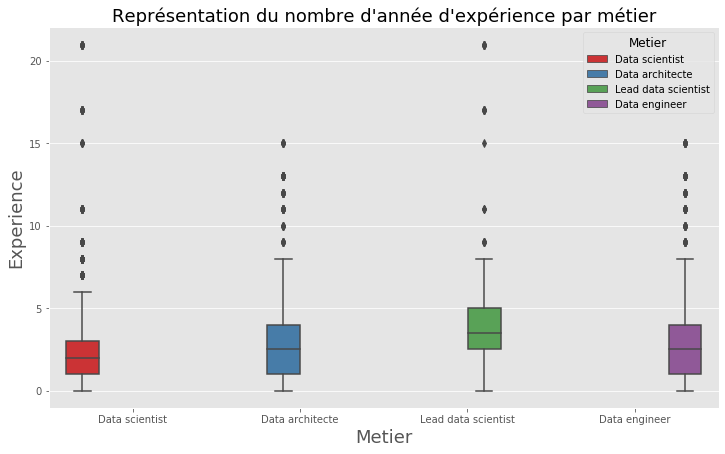

In [683]:
plt.figure(figsize=(12, 7))
b =  sb.boxplot(x="Metier", y="Experience",
            hue="Metier", data=df, palette="Set1")
b.axes.set_xlabel("Metier",fontsize=18)
b.axes.set_ylabel("Experience",fontsize=18)
b.axes.set_title("Représentation du nombre d'année d'expérience par métier",fontsize=18)

In [684]:
print(round(df.groupby('Metier').var(),2))

                     Experience
Metier                         
Data architecte            7.42
Data engineer              7.65
Data scientist             6.33
Lead data scientist        7.26


In [685]:
print(round(df.groupby('Metier').median(),2))

                     Experience
Metier                         
Data architecte             2.5
Data engineer               2.5
Data scientist              2.0
Lead data scientist         3.5


Ce box-plot permet de visualiser les concepts tels que la symétrie, la dispersion ou la centralité des distributions des valeurs associées à la variable `Expérience`. 

Remarque: **Les 4 classes contiennent des valeurs extremes (outliers)**

**ANOVA: Test de comparaison des moyennes**

In [686]:
from sklearn.feature_selection import f_classif

**Creation of a data frame:**

In [687]:
Annova_df = pd.DataFrame(df['Experience']) 
Annova_df["Metier"] = df['Metier']
Annova_df.dropna(inplace = True) # Delete all rows with one or two NA

In [688]:
X =  np.array(Annova_df['Experience']).reshape(-1, 1)
y = Annova_df['Metier'].astype('category').cat.codes

Annova_res = f_classif(X, y)
print(f'The F-Score is equal to {round(float(Annova_res[0]), 2)}, associating to a p-value of {float(Annova_res[1]):.2e}.')

The F-Score is equal to 143.09, associating to a p-value of 1.08e-90.


**Interprétation:** Le nombre moyen d'années d'expérience par profession est statistiquement différent.

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

#### a) Imputation des données manquantes de la variable expérience:

*Rappel:*

In [689]:
Nbre_na_da = df["Experience"][df["Metier"] == 'Data architecte'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Data architectes {Nbre_na_da}.')

Nbre_na_lds = df["Experience"][df["Metier"] == 'Lead data scientist'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Lead data scientists {Nbre_na_lds}.')

Nombre de valeurs manquantes pour les Data architectes 23.
Nombre de valeurs manquantes pour les Lead data scientists 19.


**Calcul des moyennes d'experience pour les profession:**
- Data architecte 
- Lead data scientist

In [690]:
Exp_da = df['Experience'][df['Metier'] == 'Data architecte']
Mean_exp_da = Exp_da.mean(axis=0, skipna=True)

In [691]:
Exp_lds = df['Experience'][df['Metier'] == 'Lead data scientist']
Mean_exp_lds = Exp_lds.mean(axis=0, skipna=True)

**Imputation des valeurs manquants par la moyenne par professsion**

In [692]:
Index_missing_values_da = list(df[df['Metier'] == 'Data architecte'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_da, 4] =  Mean_exp_da

In [693]:
Index_missing_values_lds  = list(df[df['Metier'] == 'Lead data scientist'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_lds, 4] =  Mean_exp_lds

#### b) Transformation des données manquantes de la variable Metier par 'Unknown'

In [694]:
print(f"Nombre de valeurs manquantes pour la variable Metier: {df['Metier'].isna().sum()}.")

Nombre de valeurs manquantes pour la variable Metier: 19.


In [695]:
df['Metier'].fillna('Unknown', inplace = True)

#### c) Création d'une variable catégorielle pour expérience

**Spécification de la stratégie:**

Les quantiles pour chaque profession définissent les labels d'expérience tels que:
* If Exp < quantile(0.25) => Exp_label = Débutant
* Elif Exp in [quantile(0.25), quantile(0.5)) = Confirmé
* Elif Exp in [quantile(0.5), quantile(0.75)) = Avancé
* Else Exp >= quantile(0.75) = Expert


In [696]:
print(f"""Cette stratégie permet de prendre en compte les spécificités d'évolution de chaque profession. 
Ainsi un Lead data scientist est considéré comme confirmé après {df['Experience'][df['Metier'] =='Lead data scientist'].quantile(q=0.25)} 
années d'expérience tandis qu'un data scientist après seulement {df['Experience'][df['Metier'] =='Data scientist'].quantile(q=0.25)} année.""")

Cette stratégie permet de prendre en compte les spécificités d'évolution de chaque profession. 
Ainsi un Lead data scientist est considéré comme confirmé après 2.5 
années d'expérience tandis qu'un data scientist après seulement 1.0 année.


**Création d'une colonne vide `Exp_label`:**

In [697]:
df['Exp_label'] = np.nan

In [698]:
Metier_l = list(set(df['Metier'])) # Set of Metier => 4 elements
quantile_label = {0.25:'debutant', 0.5:'confirme', 0.75:'avance', 0.76:'expert'} # Dictionary
for i in Metier_l:
    for ql in quantile_label:
        if ql <= 0.75: # No expert
            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].loc[df['Experience'] < df['Experience'].quantile(q=ql),'Experience'].index)
            df.iloc[ind , 6] = quantile_label[ql]
        else: # Expert 
            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].index)
            df.iloc[ind , 6] = quantile_label[ql]

**Remarque:**
- La discrétisation de la variable expérience aurait pu être effectuée en utilisant les quantiles sans tenir compte des métiers telle que:

In [699]:
"""MetierL= list(set(df['Metier']))
quantile_label = {0.25:'debutant', 0.5:'confirme', 0.75:'avance', 0.76:'expert'}
for i in MetierL:
    for ql in quantile_label:
        if ql <= 0.75:
            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].loc[df['Experience'] < df['Experience'].quantile(q=ql),'Experience'].index)
            df.iloc[ind , 6] = quantile_label[ql]
        else: # Expert class
            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].index)
            df.iloc[ind , 6] = quantile_label[ql]"""

"MetierL= list(set(df['Metier']))\nquantile_label = {0.25:'debutant', 0.5:'confirme', 0.75:'avance', 0.76:'expert'}\nfor i in MetierL:\n    for ql in quantile_label:\n        if ql <= 0.75:\n            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].loc[df['Experience'] < df['Experience'].quantile(q=ql),'Experience'].index)\n            df.iloc[ind , 6] = quantile_label[ql]\n        else: # Expert class\n            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].index)\n            df.iloc[ind , 6] = quantile_label[ql]"

Cette seconde stratégie a été testée pour les question 8 et 9 pour mesurer l'influence du choix de la stratégie de discrétisation de la variable `Experience`.

#### e) Representation graphique du niveau d'expérience par profession

Text(0.5, 1.0, "Répartion des niveaux d'expériece par métier")

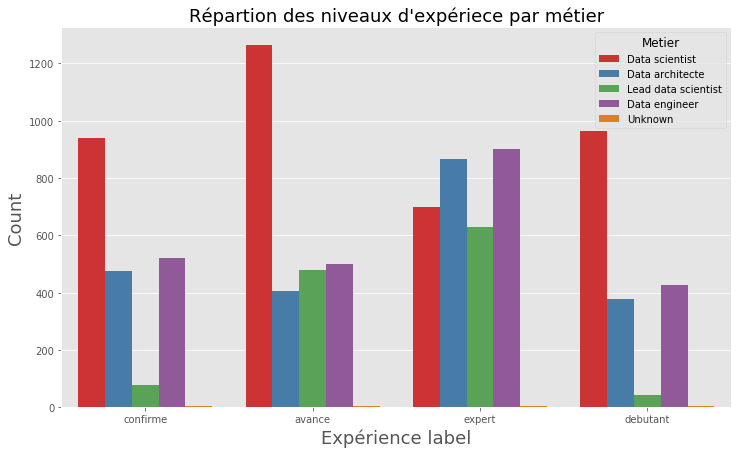

In [700]:
plt.figure(figsize=(12, 7))
b =  sb.countplot( x="Exp_label", hue="Metier", data=df, palette="Set1")

b.axes.set_xlabel("Expérience label",fontsize=18)
b.axes.set_ylabel("Count",fontsize=18)
b.axes.set_title("Répartion des niveaux d'expériece par métier",fontsize=18)

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [701]:
# Transformation of Technologies column
l =[]
techno = df['Technologies']
for i in range(len(techno)): # For each individual save independently each technology in `v`  
    v = re.split('/', techno[i], flags=re.IGNORECASE) 
    for i in range(len(v)): # Add each technologies in a final vector l
        l.append(v[i])

# Creation of a data frame summarizing the occurence of each technology
data_technologie = pd.Series(l).value_counts()
data_techno = data_technologie.to_frame().reset_index()
data_techno.columns = ['technologie', 'frequence']
data_techno.head()

,technologie,frequence
0,Python,6627
1,R,4374
2,SQL,2581
3,Java,1719
4,Hadoop,1589


In [702]:
# Extraction of the five most used technologies
top5 = data_techno.iloc[0:5]
print(top5)

  technologie  frequence
0      Python       6627
1           R       4374
2         SQL       2581
3        Java       1719
4      Hadoop       1589


Text(0.5, 1.0, 'Top 5 des tecnhologies')

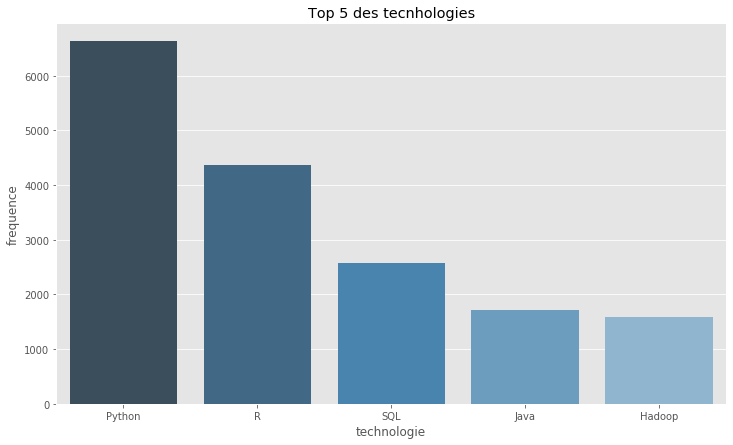

In [703]:
plt.figure(figsize=(12,7))
sb.barplot('technologie', 'frequence', data=top5, palette="Blues_d").set_title("Top 5 des tecnhologies")

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### a) Preprocessing
Pour les questions 8 et 9, chacune des variable catégorielles doit être discrétisée. Un encodage de type binaire de type "one-hot-encoding" a été choisi.

**Preprocessing `Entreprises`**

In [704]:
s = pd.Series(list(df['Entreprise']))
one_hot_encoding_entreprise = pd.get_dummies(s) # Binary matrix

# Each company with less than 30 employees is removed, since they can be considered as not informative.
indexL = []
for i in range(one_hot_encoding_entreprise.shape[1]):
    if one_hot_encoding_entreprise.iloc[:,i].sum() < 30:
        indexL.append(i)
one_hot_encoding_entreprise = one_hot_encoding_entreprise.drop(one_hot_encoding_entreprise.columns[indexL], axis=1)

In [705]:
print(f"{one_hot_encoding_entreprise.shape[1]} entreprises ont été conservées.")

49 entreprises ont été conservées.


**Preprocessing `Technologies`**

In [706]:
Ltechno = []
techno = df['Technologies']
for i in range(len(techno)):
    v = re.split('/', techno[i], flags=re.IGNORECASE)
    for i in range(len(v)):
        Ltechno.append(v[i])
set_Techno = list(set(Ltechno))                
set_Techno = set_Techno[1:len(set_Techno)] # Remove the empty techno

# Initialisation of Technilogies' data frame
MTechno = np.zeros((df.shape[0], len(set_Techno))) 
dfTechno = pd.DataFrame(MTechno)
dfTechno.columns =  list(set(Ltechno))[1:] # Columns' name

# For each individual if he/she knows the technology i write 1 in the corresponding row and column.
for i in range(len(set_Techno)):
    for j in range(df.shape[0]):
        if df['Technologies'][j].find(set_Techno[i]) != -1:
            dfTechno.iloc[j,i] = 1

In [707]:
print(f"{dfTechno.shape[1]} technologies ont été conservées.")

60 technologies ont été conservées.


In [708]:
print(f"""Remarque: chaque technologie est connue par au moins {int(sorted(dfTechno.sum())[0])},
c'est pourquoi toutes ont été conservées.""")

Remarque: chaque technologie est connue par au moins 35,
c'est pourquoi toutes ont été conservées.


**Preprocessing `Diplome`**

In [709]:
s_diplome = pd.Series(list(df['Diplome']))
one_hot_encoding_diplome = pd.get_dummies(s_diplome)
print(f"Dimensions de la table diplôme {one_hot_encoding_diplome.shape}.")

Dimensions de la table diplôme (9582, 4).


**Preprocessing `Metier`**

In [710]:
# metier 
s_metier = pd.Series(list(df['Metier']))
one_hot_encoding_metier = pd.get_dummies(s_metier)

In [711]:
print(f"Dimensions de la table Metier  {one_hot_encoding_metier.shape} (rappel les NA ont été subtitués par 'Unknown').")

Dimensions de la table Metier  (9582, 5) (rappel les NA ont été subtitués par 'Unknown').


**Preprocessing `Exp_label`**

In [712]:
s_experience = pd.Series(list(df['Exp_label']))
one_hot_encoding_experience = pd.get_dummies(s_experience)
print(f"Dimensions de la table Exp_label  {one_hot_encoding_experience.shape} .")

Dimensions de la table Exp_label  (9582, 4) .


Nombre d'individus par catgorie:

In [713]:
print(one_hot_encoding_experience.sum(axis=0))

avance      2650
confirme    2019
debutant    1815
expert      3098
dtype: int64


**Remarque:**
Étant donné que seule la variable Experience est numérique, il semble plus cohérent d'utiliser sa forme catégorielle dans la suite de l'analyse. 

**Preprocessing `Ville`**

In [714]:
s_ville = pd.Series(list(df['Ville']))
one_hot_encoding_ville = pd.get_dummies(s_ville)
print(f"{one_hot_encoding_ville.shape[1]} sont retenues, toutes ont au minimum {sorted(one_hot_encoding_ville.sum(axis=0))[0]} employés.")

14 sont retenues, toutes ont au minimum 87 employés.


#### b) Fusion des  différentes matrices

In [715]:
# merge all data transform
df_merge = pd.concat([one_hot_encoding_diplome, 
                      one_hot_encoding_entreprise, 
                      dfTechno,
                      one_hot_encoding_ville , 
                      one_hot_encoding_experience,
                      one_hot_encoding_metier], axis=1)

In [716]:
df_merge.shape

(9582, 136)

In [717]:
print(f'le nouveau data frame binaire contient {df_merge.shape[0]} observations et {df_merge.shape[1]} variables.')
print(f'Le daframe initial contient {df.shape[0]} observation et {df.shape[1]-1} variables')

le nouveau data frame binaire contient 9582 observations et 136 variables.
Le daframe initial contient 9582 observation et 6 variables


In [718]:
df_merge.head()

,Bachelor,Master,No diploma,Phd,Accenture,"Advanced Micro Devices, Inc.",Allstate,Amazon.com,Ball Aerospace,Bank of America,...,Toulouse,avance,confirme,debutant,expert,Data architecte,Data engineer,Data scientist,Lead data scientist,Unknown
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


**Ce problème de classification sera résolu en deux étapes:**
+ 1) Réduction de la dimension via une ACP
    * Sélection des n composantes principales les plus importantes
+ 2) Réalisation d'un KMeans sur l'espace réduit

**L'interprétation des clusters dépendra donc de la corrélation des variables avec les n axes principaux conservés.**

#### C) Réduction de la dimension

**Remarque:** Étant donné que les varianbles sont dicotomiques les ACP ne seront pas centrées.

In [719]:
from sklearn.decomposition import PCA

In [720]:
acp = PCA(svd_solver='full')
acp1 = acp.fit_transform(df_merge)

In [721]:
print(acp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)


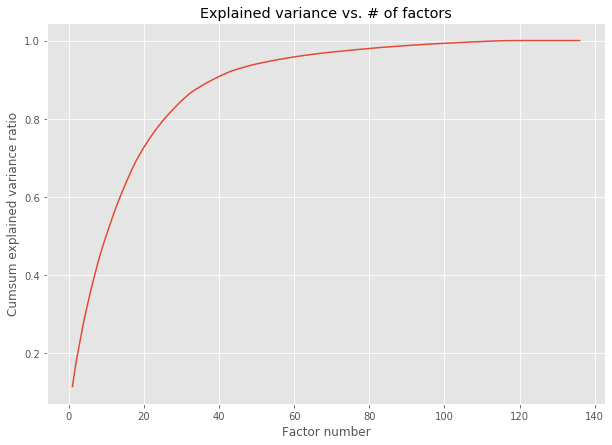

In [722]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1,df_merge.shape[1]+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

D'après cette première ACP, il semble que les 20 premières composantes expliquent à elles seules près de 80% de la variance. Ainsi nous allons réaliser une seconde ACP sur 20 axes, pour déduire plus finement le nombre de composantes à conserver.

Text(0.5, 1.0, 'Explained variance by features')

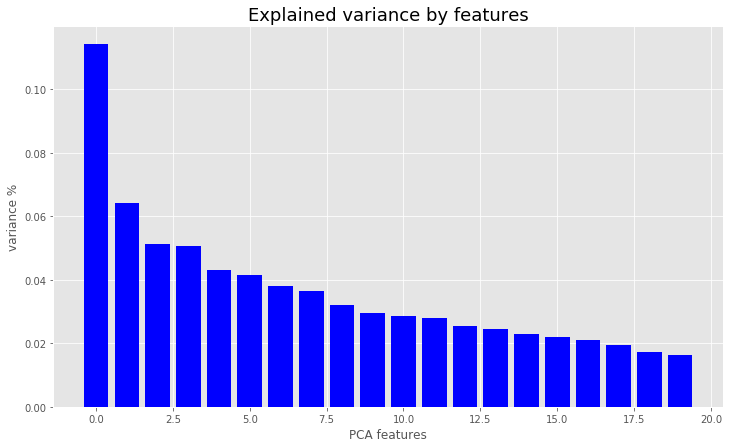

In [723]:
plt.figure(figsize=(12, 7))
acp2 = PCA(n_components= 20)
Principal_components = acp2.fit_transform(df_merge)

# Plot of explained variance by principal component
plt.bar(range(acp2.n_components_), acp2.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.title("Explained variance by features",fontsize=18)

In [724]:
print(f"Seules les {len(acp2.explained_variance_ratio_[acp2.explained_variance_ratio_ > 0.05])} premières composantes\
principales exppliquent plus de 5% de la variance. Ainsi seuls les 4 premiers axes seront conservés.")

Seules les 4 premières composantesprincipales exppliquent plus de 5% de la variance. Ainsi seuls les 4 premiers axes seront conservés.


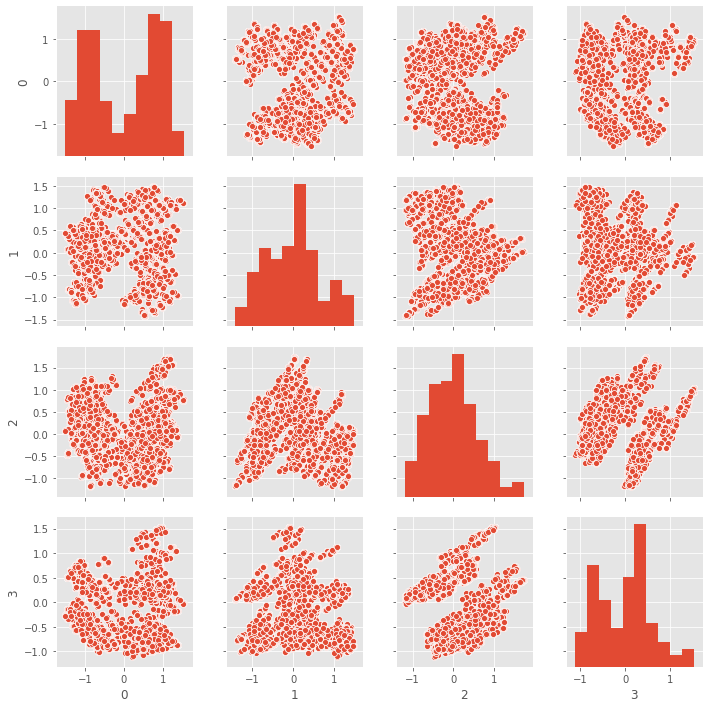

In [725]:
# Save the frist 4th components into a data frame
PCA_components = pd.DataFrame(Principal_components[:,:4])
sb.pairplot(PCA_components)

**Au regard de la distributions des nuages de points observés ci-dessus nous confirmons qu'un algorithm de clustering de type KMeans pourrait convenir. En effet deux cllusters se déssinent entre les différents axes.**

#### D) Algorithm KMeans

In [726]:
from sklearn.cluster import KMeans

In [727]:
model = KMeans(n_clusters=2)
model.fit(PCA_components)
label_Kmeans = model.labels_

In [728]:
PCA_components['Label'] = label_Kmeans
PCA_components['Label'] = PCA_components['Label'].astype('category')

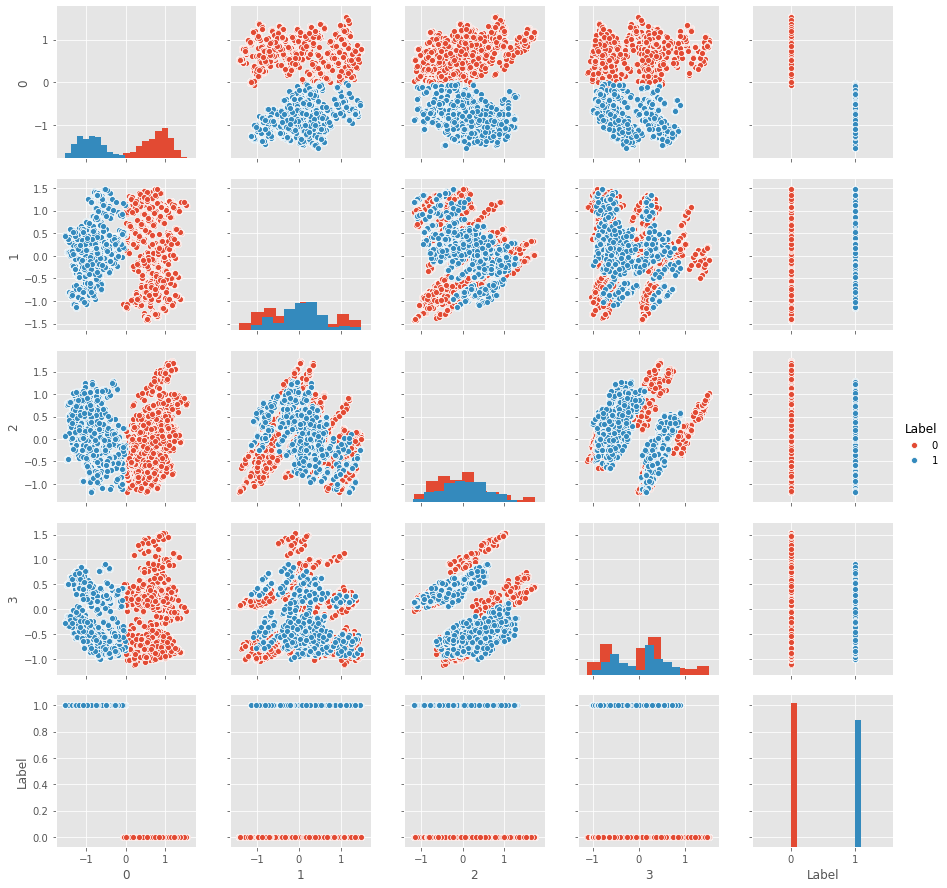

In [729]:
sb.pairplot(PCA_components, hue = 'Label', diag_kind =  'hist')

**Interprétation:** l'Axe 0 est le plan séparant les deux clusters.

#### E) Interprétation

**Analyse de la corrélation des variables axes.**

In [730]:
n = PCA_components.shape[0] # Numeber of individuals
corvar = np.zeros((acp2.components_.shape[1],acp2.components_.shape[0]- 1))
eigval = (n-1)/n*acp2.explained_variance_
sqrt_eigval = np.sqrt(eigval)

for k in range(acp2.components_.shape[0]- 1):
    corvar[:,k] = acp2.components_[k,:] * sqrt_eigval[k]

In [731]:
corvar  = pd.DataFrame(corvar)
corvar.set_index(df_merge.columns, inplace = True)
colnames = []
for i in range(corvar.shape[1]):
    colnames.append('col' + str(i))
corvar.columns = colnames

In [732]:
def cor_plot(corvar, PCA_components, Colname_1, Colname_2, Axes_n1, Axes_n2):
    """
    cor_plot prints the 10 most correlated features with Axes_n1, and respectively with Axes_n2 of the PCA;
    and plots these correlations next to the corresponding factotrial map with the labels. 
    
    corvar (pd.DataFrame): Data frame of correlations with the correlations of each features (rows) 
                           according to the differents axes (cols);
    PCA_components (pd.DataFrame): Coordinates of each individual according to each PCA's axes;
    Colname_1 (str): colnames of corvar number 1, ie first axe to sort (also equal to col+Axes_n1);  
    Colname_2 (str): colnames of corvar number 2, ie second axe to sort (also equal to col+Axes_n2);
    Axes_n1 (int) : colums number 1 of PCA_components;
    Axes_n2 (int) : colums number 2 of PCA_components;
    """
    corvar_sort_axes0 = corvar.sort_values(by= Colname_1, ascending = True)
    corvar_sort_axes1 = corvar.sort_values(by= Colname_2, ascending = True)
    print(f"Les 10 variables les plus corélées avec l'axe {Axes_n1} sont :\n {list(corvar_sort_axes0.index[:10])}")
    print(f"Les 10 variables les plus corélées avec l'axe {Axes_n2} sont :\n {list(corvar_sort_axes1.index[:10])}")


    fig, axes = plt.subplots(figsize=(16,8)) 
    plt.subplot(121)
    for j in range(10): 
        plt.annotate(corvar_sort_axes0.index[j],(corvar_sort_axes0.iloc[j,0]-0.1, corvar_sort_axes0.iloc[j,1]))
        plt.arrow(0, 0, corvar_sort_axes0.iloc[j,0], corvar_sort_axes0.iloc[j,1], head_width=0.01, head_length=0.01,
              fc='r', ec='r',  color="r")

    for j in range(10): 
        plt.annotate(corvar_sort_axes1.index[j],(corvar_sort_axes1.iloc[j,0], corvar_sort_axes1.iloc[j,1] - 0.05))
        plt.arrow(0, 0, corvar_sort_axes1.iloc[j,0], corvar_sort_axes1.iloc[j,1], head_width=0.01, head_length=0.01,
              fc='b', ec='b', color="b")
    
    plt.plot([-0.4,0.4],[0,0],color='silver',linestyle='-',linewidth=1) 
    plt.plot([0,0],[-0.4,0.4],color='silver',linestyle='-',linewidth=1)

    plt.subplot(122)
    plt.scatter(PCA_components.iloc[:,Axes_n1],PCA_components.iloc[:,Axes_n2], c = PCA_components['Label'])

    plt.show()

Les 10 variables les plus corélées avec l'axe 0 sont :
 ['Data engineer', 'Data architecte', 'Java', 'expert', 'Linux', 'MongoDB', 'Hadoop', 'Docker', 'Elasticsearch', 'Kibana']
Les 10 variables les plus corélées avec l'axe 1 sont :
 ['SQL', 'R', 'SAS', 'Hadoop', 'Teradata', 'Lead data scientist', 'Hive', 'MongoDB', 'Anglais', 'Machine learning']


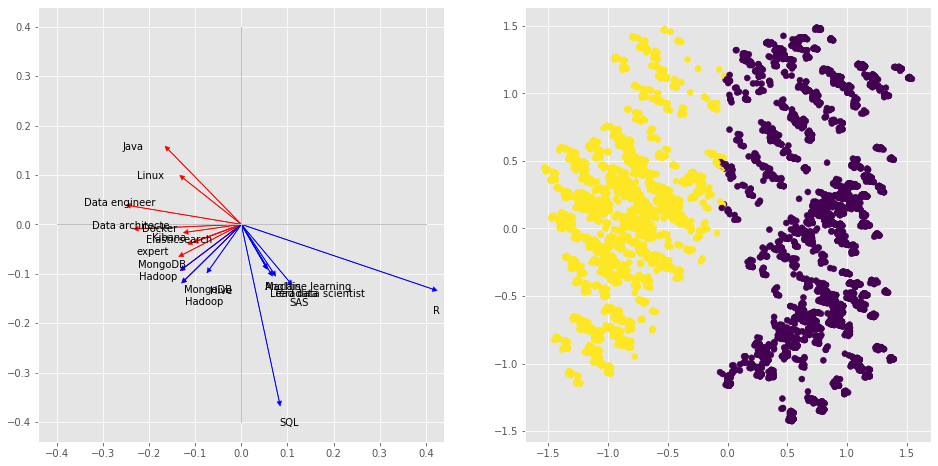

In [733]:
cor_plot(corvar, PCA_components, 'col0', 'col1', 0, 1)

Les 10 variables les plus corélées avec l'axe 0 sont :
 ['Data engineer', 'Data architecte', 'Java', 'expert', 'Linux', 'MongoDB', 'Hadoop', 'Docker', 'Elasticsearch', 'Kibana']
Les 10 variables les plus corélées avec l'axe 2 sont :
 ['Python', 'Master', 'Lead data scientist', 'SQL', 'C', 'C++', 'expert', 'Linux', 'Data engineer', 'Teradata']


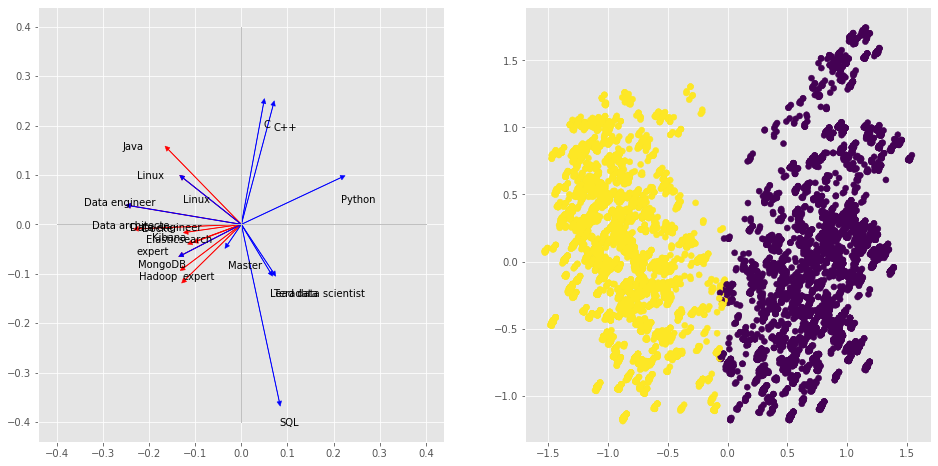

In [734]:
cor_plot(corvar, PCA_components, 'col0', 'col2', 0, 2)

Les 10 variables les plus corélées avec l'axe 0 sont :
 ['Data engineer', 'Data architecte', 'Java', 'expert', 'Linux', 'MongoDB', 'Hadoop', 'Docker', 'Elasticsearch', 'Kibana']
Les 10 variables les plus corélées avec l'axe 3 sont :
 ['Phd', 'Python', 'Bachelor', 'SQL', 'No diploma', 'Spark', 'expert', 'Tensorflow', 'Hadoop', 'Big data']


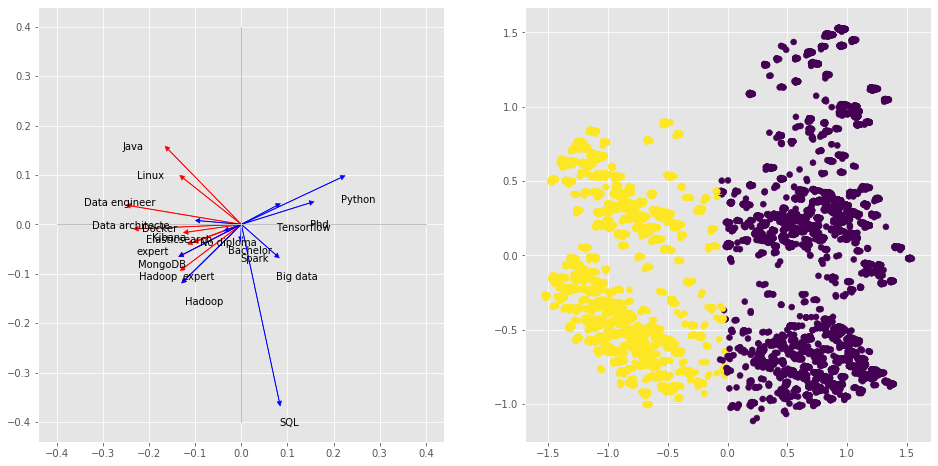

In [735]:
cor_plot(corvar, PCA_components, 'col0', 'col3', 0, 3)

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### Etape 1: Data preprocessing

**1)**  Division du data frame `df_merge` entre les lignes dont le métier est connu et les lignes dont le métier est inconnu.

In [736]:
indexUnknown = df_merge[df_merge['Unknown'] == 1 ].index
df_unknown = df_merge.iloc[indexUnknown, ]
df_known = df_merge
df_known.drop(indexUnknown, inplace=True)

In [737]:
indexUnknown = df_merge[df_merge['Unknown'] == 1 ].index
indexUnknown

Int64Index([], dtype='int64')

**2)** Supréssion des colonnes métiers

In [738]:
df_known = df_known.iloc[: , :df_merge.shape[1] - 5]
df_unknown = df_unknown.iloc[: , : df_unknown.shape[1] - 5] 

**3)** Préparation de la variable à prédire

In [739]:
df_metier_known = df['Metier']
IndexMissingMetier = list(df_metier_known[df_metier_known == 'Unknown'].index)
df_metier_known.drop(IndexMissingMetier  , inplace=True)

#### Etape 2: Création des jeux de données train et test

In [740]:
from sklearn.model_selection import train_test_split

In [741]:
X_train, X_test, y_train, y_test = train_test_split( df_known, df_metier_known, test_size=0.33, random_state=0)

#### Etape 3:  Sélection de variables

Contrairement à la question précédente, nous voulons conserver les "vrai" variables et non les composantes principales. Ainsi nous utiliserons un score de corrélations liés au test du chi2 (test d'indépendance). Cette métrique est plus adaptée qu'une corrélation de Pearson étant donné que les variables sont catégorielles. 

In [742]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [743]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

Text(0.5, 1.0, 'Score par variable')

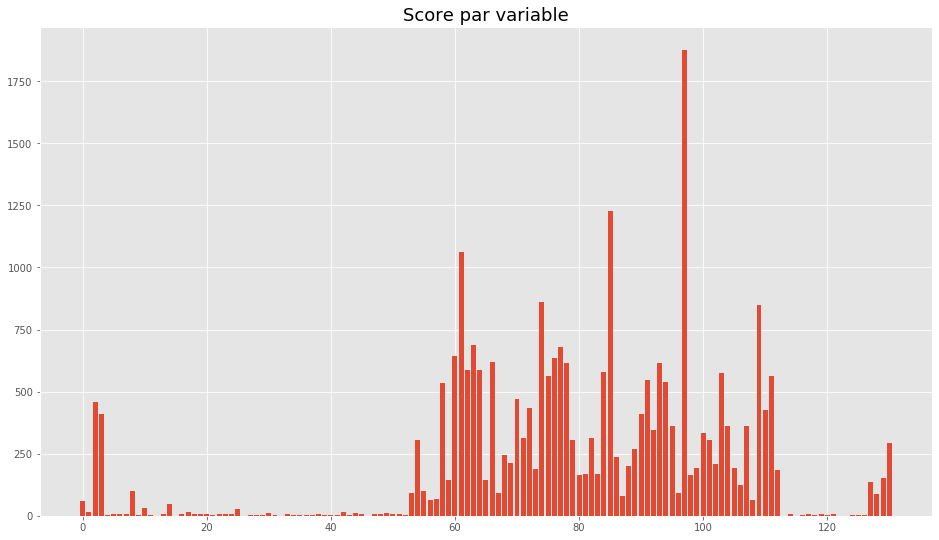

In [744]:
plt.figure(figsize=(16, 9))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title("Score par variable",fontsize=18)

In [745]:
# Data Frame of features' score
fsScore  =  pd.DataFrame( fs.scores_)
# Determination of a threshold score according to scores' quantile in order to keep 30% of the features
ThresholdScore = fsScore.iloc[:,0].quantile(0.7)
# Features to keep
IndexKeptFeatures = fsScore[fsScore.iloc[:,0] > ThresholdScore].index
# Resulting data frames (_s for selected)
X_train_s = X_train.iloc[:, IndexKeptFeatures]
X_test_s = X_test.iloc[:, IndexKeptFeatures] 
df_unknown = df_unknown.iloc[:, IndexKeptFeatures]

In [746]:
print(X_train_s.shape, X_test_s.shape, df_unknown.shape)

(6407, 39) (3156, 39) (19, 39)


**Affichage des colonnes sélectionnées**

In [747]:
df_known.columns[IndexKeptFeatures]

Index(['No diploma', 'Phd', 'PIG', 'Matlab', 'Java', 'Linux', 'Vertica',
       'MariaDB', 'Tableau', 'machine learning', 'Hadoop', 'Redshift', 'Yarn',
       'Excel', 'Big data', 'Elasticsearch', 'Docker', 'VBA', 'Map-Reduce',
       'Hive', 'Tensorflow', 'AWS', 'C++', 'Teradata', 'SAS', 'scikit-learn',
       'MongoDB', 'HDFS', 'Machine learning', 'R', 'Python', 'HBASE', 'Kibana',
       'Anglais', 'SQL', 'GNU', 'PostgreSQL', 'Kafka', 'expert'],
      dtype='object')

#### Etape 4:  Méthode 1 prédiction par Random Forest

In [748]:
from sklearn.ensemble import RandomForestClassifier

Le nombre minimal d'échantillon pour effectuer un split sera optimisé, remarque cette démarche est quasi équivalente à l'optimisation du nombre d'échantillon par feuille.

In [749]:
precL = []
for i in range(10,6400,50): 
    # Model building 
    clf = RandomForestClassifier(n_estimators = 10, min_samples_split = i , random_state=0)
    # Training
    clf.fit(X_train_s, y_train)
    # Prediction on test data set
    y_pred = clf.predict(X_test_s)
    # Score through precision metric
    prec = float(np.sum(y_pred == y_test)) / len(y_test)
    precL.append(prec)

Text(0.5, 0, 'min_samples_split')

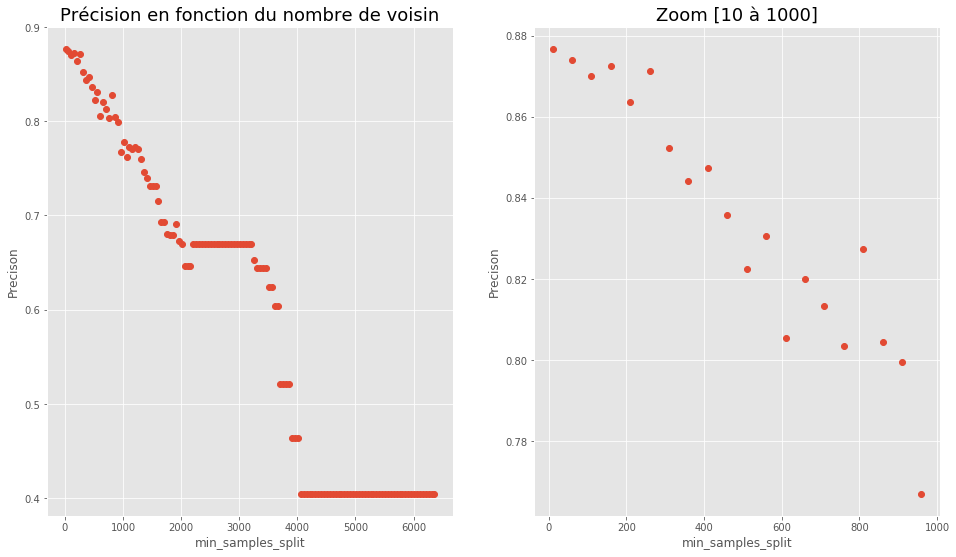

In [750]:
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.plot(range(10,6400,50), precL,'o')
plt.title("Précision en fonction du nombre de voisin",fontsize=18)
plt.ylabel("Precison")
plt.xlabel("min_samples_split")
plt.subplot(122)
plt.plot(range(10,1000,50), precL[:20], 'o')
plt.title("Zoom [10 à 1000]",fontsize=18)
plt.ylabel("Precison")
plt.xlabel("min_samples_split")

**Conclusion: La précison optimale est obtenue pour un nombre minimal de 10 objets par split.** 

In [350]:
# Model building 
clf = RandomForestClassifier(n_estimators = 500, min_samples_split = 10 , random_state=0)
# Training
clf.fit(X_train_s, y_train)
# Prediction on test data set
y_pred = clf.predict(X_test_s)
# Score through precision metric
prec = float(np.sum(y_pred == y_test)) / len(y_test)
print(f"La precision sur le jeu de donné test est de {prec:.3f}.")
# Prediction of missing values
Metier_missing_RF = clf.predict(df_unknown)

La precision sur le jeu de donné test est de 0.875.


#### Etape 5:  Méthode 2 -  prédiction par K Nearest Neighbour

Cette seconde méthode a été implantée pour comparer les résultats obtenus par le Random Forest.
Nous chercherons a optimiser en fonction de la précision le paramètre `n_neighbor`.

In [356]:
from sklearn.neighbors import KNeighborsClassifier

In [357]:
precL = []
for i in range(10,6400,50): # 6407 Size of X_test
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_s, y_train)
    y_predKnn = neigh.predict(X_test_s)
    prec = float(np.sum(y_predKnn == y_test)) / len(y_test)
    precL.append(prec)

#Metier_MISSING_KNN = clf.predict(dfUnknown)

Text(0.5, 1.0, 'Zoom [10 à 1000]')

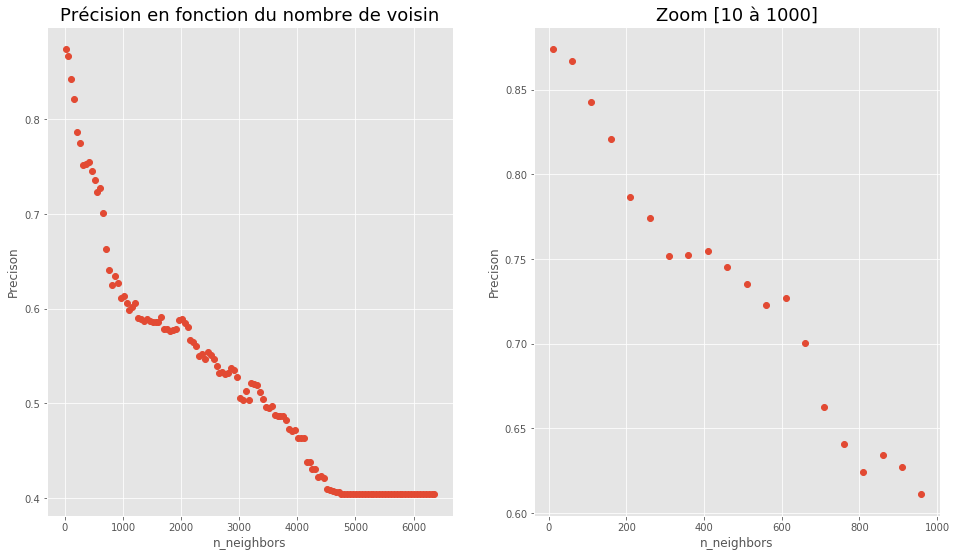

In [358]:
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.plot(range(10,6400,50), precL,'o')
plt.title("Précision en fonction du nombre de voisin",fontsize=18)
plt.ylabel("Precison")
plt.xlabel("n_neighbors")
plt.subplot(122)
plt.plot(range(10,1000,50), precL[:20], 'o')
plt.ylabel("Precison")
plt.xlabel("n_neighbors")
plt.title("Zoom [10 à 1000]",fontsize=18)

**Conclusion:** 10 est le nombre optimal de voisin par rapport à la précision.

In [489]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train_s, y_train)
y_predKnn = neigh.predict(X_test_s)
prec = float(np.sum(y_predKnn == y_test)) / len(y_test)
print(prec)

Metier_missing_KNN = clf.predict(df_unknown)

0.8742078580481623


**Etape 6: Missing values**

In [487]:
Metier_missing_RF

array(['Data engineer', 'Data scientist', 'Data scientist',
       'Data scientist', 'Data architecte', 'Data scientist',
       'Data scientist', 'Lead data scientist', 'Data engineer',
       'Data scientist', 'Data architecte', 'Data engineer',
       'Data architecte', 'Data scientist', 'Data engineer',
       'Data scientist', 'Data architecte', 'Data scientist',
       'Lead data scientist'], dtype=object)

In [490]:
Metier_missing_KNN

array(['Data engineer', 'Data scientist', 'Data scientist',
       'Data scientist', 'Data architecte', 'Data scientist',
       'Data scientist', 'Lead data scientist', 'Data engineer',
       'Data scientist', 'Data architecte', 'Data engineer',
       'Data architecte', 'Data scientist', 'Data engineer',
       'Data scientist', 'Data architecte', 'Data scientist',
       'Lead data scientist'], dtype=object)

In [491]:
Metier_missing_RF == Metier_missing_KNN

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

**Conclusion: Les deux méthodes donnent exactement les mêmes prédictions. Au regard de la complexité d'un RandomForest en comparaison d'un KNN, la méthode des KNN reste à privilégier dans ce cas.** 

### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix
